# Manipulation of cooler files
Sometimes it is necessary to change the data stored in a cooler file. Perhaps, you want to remove coms chromosomes, rename them, or completely rearrange them.

Here we are collecting some examples of how to do some common operations to achieve these type of goals.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cooler
import matplotlib.pyplot as plt
import cooltools
import bioframe
import numpy as np

In [3]:
# download test data
# this file is 145 Mb, and may take a few seconds to download
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./data/')    
print(cool_file)

./data/test.mcool


In [4]:
# Load a Hi-C map at a 1000kb resolution from a cooler file.
clr = cooler.Cooler('./test.mcool::/resolutions/1000000')

In [5]:
# Use bioframe to fetch the genomic features.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_viewframe(bioframe.make_chromarms(hg38_chromsizes,  hg38_cens))
hg38_arms = hg38_arms[hg38_arms.chrom.isin(clr.chromnames)].reset_index(drop=True)
hg38_arms

,chrom,start,end,name
0,chr2,0,93900000,chr2_p
1,chr2,93900000,242193529,chr2_q
2,chr17,0,25100000,chr17_p
3,chr17,25100000,83257441,chr17_q


## How to rename chromosome in a cooler file?

In [6]:
clr.chromnames

['chr2', 'chr17']

In [7]:
cooler.rename_chroms(clr, {chrom:chrom.lstrip('chr') for chrom in clr.chromnames}) #Remove 'chr' from chromosome names to follow ENSEMBLE convention

In [8]:
clr.chromnames

['2', '17']

Now let's rename it back to UCSC convention.

In [9]:
cooler.rename_chroms(clr, {chrom:f'chr{chrom}' for chrom in clr.chromnames}) #Add 'chr' from chromosome names to follow ENSEMBLE convention

In [10]:
clr.chromnames

['chr2', 'chr17']

## How to directly manipulate data stored in the cooler
For example, sometimes one can encounter cooler files where the balancing weights were created using different tools, such as hic2cool, and they are divisive (i.e. to obtain normalised values the pixel counts need to be divided by the weight, instead of the standard `cooler` convention of multiplicative weights). This is how one can invert the weights manually and save into a new column in the cooler file, so that the file is compatible with `cooltools`.

In [11]:
import h5py

In [12]:
clr.bins()[:10]

,chrom,start,end,weight
0,chr2,0,1000000,0.002441
1,chr2,1000000,2000000,0.002435
2,chr2,2000000,3000000,0.002728
3,chr2,3000000,4000000,0.001755
4,chr2,4000000,5000000,0.002474
5,chr2,5000000,6000000,0.002753
6,chr2,6000000,7000000,0.002339
7,chr2,7000000,8000000,0.002426
8,chr2,8000000,9000000,0.002160
9,chr2,9000000,10000000,0.002243


In [13]:
with h5py.File(clr.filename, 'r+') as f:
    f['resolutions']['1000000']['bins']['weight_inverted'] = 1/f['resolutions']['1000000']['bins']['weight'][:]

In [14]:
clr.bins()[:10]

,chrom,start,end,weight,weight_inverted
0,chr2,0,1000000,0.002441,409.720297
1,chr2,1000000,2000000,0.002435,410.722267
2,chr2,2000000,3000000,0.002728,366.613424
3,chr2,3000000,4000000,0.001755,569.861097
4,chr2,4000000,5000000,0.002474,404.249506
5,chr2,5000000,6000000,0.002753,363.256323
6,chr2,6000000,7000000,0.002339,427.527915
7,chr2,7000000,8000000,0.002426,412.216115
8,chr2,8000000,9000000,0.002160,463.015724
9,chr2,9000000,10000000,0.002243,445.760338


Now let's remove this new column, since in this case it not needed.

In [15]:
with h5py.File(clr.filename, 'r+') as f:
    del f['resolutions']['1000000']['bins']['weight_inverted']

In [16]:
clr.bins()[:10]

,chrom,start,end,weight
0,chr2,0,1000000,0.002441
1,chr2,1000000,2000000,0.002435
2,chr2,2000000,3000000,0.002728
3,chr2,3000000,4000000,0.001755
4,chr2,4000000,5000000,0.002474
5,chr2,5000000,6000000,0.002753
6,chr2,6000000,7000000,0.002339
7,chr2,7000000,8000000,0.002426
8,chr2,8000000,9000000,0.002160
9,chr2,9000000,10000000,0.002243


## How to rearrange the data in a cooler in an arbitrary order

If we create a genomic view that is a subset of the the assembly used to create a cooler, we can use the `rearrange_cooler` function from cooltools to create a new cooler with the new order of the data. Each region can be inverted, and the assigned chromosome name can be changed.

### New view with all regions included

In [17]:
from cooltools.api.rearrange import rearrange_cooler #Note that this function is only availalbe in cooltools versions above 0.5.4

In [18]:
new_view = hg38_arms.iloc[[0, 2, 1, 3]].reset_index(drop=True).copy()
new_view['new_chrom'] = ['fake_chrom1', 'fake_chrom1', 'fake_chrom2', 'fake_chrom2'] # new chrom names
new_view['strand'] = ['-', '+', '+', '+'] # here we are flipping the strand of chr2_p, so the data is flipped too
new_view = bioframe.trim(new_view, hg38_chromsizes)
new_view

,chrom,start,end,name,new_chrom,strand
0,chr2,0,93900000,chr2_p,fake_chrom1,-
1,chr17,0,25100000,chr17_p,fake_chrom1,+
2,chr2,93900000,242193529,chr2_q,fake_chrom2,+
3,chr17,25100000,83257441,chr17_q,fake_chrom2,+


In [19]:
rearrange_cooler(clr, new_view, 'test_reordered.cool', assembly='hg38_custom')

INFO:root:Rearranged bins
INFO:root:Created bin mapping
INFO:root:Creating a new cooler
INFO:root:Processed 100.00% pixels
INFO:root:Created a new cooler at test_reordered.cool


In [20]:
clr_new = cooler.Cooler('test_reordered.cool')

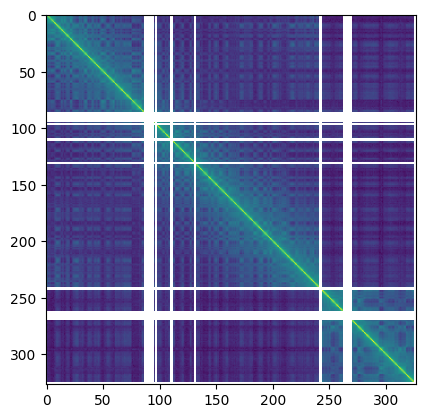

In [21]:
plt.imshow(np.log2(clr.matrix()[:]))

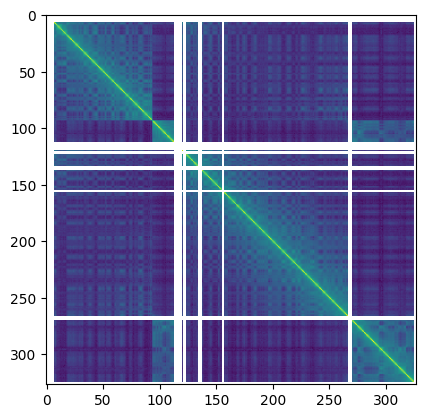

In [22]:
plt.imshow(np.log2(clr_new.matrix()[:]))

In [23]:
clr_new.chroms()[:]

,name,length
0,fake_chrom1,119000000
1,fake_chrom2,206450970


In [24]:
# Note that due to bins at the ends of chromosomes not having a "normal" length, bins after reordering can have strange coordinates, although they are still the same length
clr_new.bins()[:]

,chrom,start,end,weight
0,fake_chrom1,0,1000000,NaN
1,fake_chrom1,1000000,2000000,NaN
2,fake_chrom1,2000000,3000000,NaN
3,fake_chrom1,3000000,4000000,NaN
4,fake_chrom1,4000000,5000000,NaN
...,...,...,...,...
322,fake_chrom2,202193529,203193529,0.002830
323,fake_chrom2,203193529,204193529,0.003012
324,fake_chrom2,204193529,205193529,0.003727
325,fake_chrom2,205193529,206193529,0.003376


## New view with subset of regions

In [25]:
new_view = hg38_arms.iloc[[0, 3]].reset_index(drop=True).copy()
# Note that we don't create new chromosome names and orientations, they will be retained as were before:
new_view = bioframe.trim(new_view, hg38_chromsizes)
new_view

,chrom,start,end,name
0,chr2,0,93900000,chr2_p
1,chr17,25100000,83257441,chr17_q


In [26]:
rearrange_cooler(clr, new_view, 'test_reordered_subset.cool', new_chrom_col=None, orientation_col=None, assembly='hg38_custom')

INFO:root:Rearranged bins
INFO:root:Created bin mapping
INFO:root:Creating a new cooler
INFO:root:Processed 100.00% pixels
INFO:root:Created a new cooler at test_reordered_subset.cool


In [27]:
clr_new = cooler.Cooler('test_reordered_subset.cool')

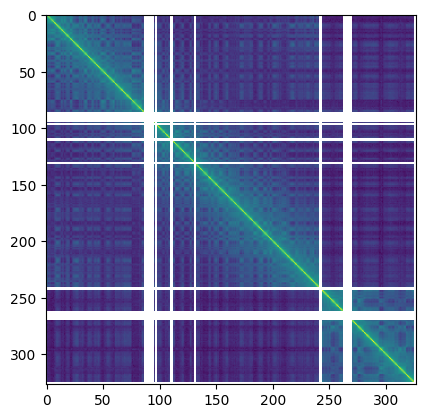

In [28]:
plt.imshow(np.log2(clr.matrix()[:]))

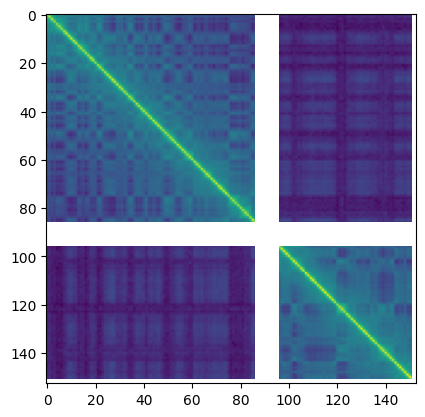

In [29]:
plt.imshow(np.log2(clr_new.matrix()[:]))

In [30]:
clr_new.chroms()[:]

,name,length
0,chr2,94000000
1,chr17,58257441


In [31]:
# Note that due to bins at the ends of chromosomes not having a "normal" length, bins after reordering can have strange coordinates, although they are still the same length
clr_new.bins()[:]

,chrom,start,end,weight
0,chr2,0,1000000,0.002441
1,chr2,1000000,2000000,0.002435
2,chr2,2000000,3000000,0.002728
3,chr2,3000000,4000000,0.001755
4,chr2,4000000,5000000,0.002474
...,...,...,...,...
148,chr17,54000000,55000000,0.002830
149,chr17,55000000,56000000,0.003012
150,chr17,56000000,57000000,0.003727
151,chr17,57000000,58000000,0.003376


In [32]:
clr_new.info['genome-assembly']

'hg38_custom'